In [1]:
import os, joblib, warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grs
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning

# Import

Import readout from experiment

In [2]:
#path = "../experiments/readout-2019-03-30T18-13/result.joblib"
#path = "../experiments/mod_rec_hennequin-2019-04-01T15-12/results/mod_rec_hennequin.joblib"
#path = "../experiments/mod_rec_hennequin-2019-04-01T09-50/result.joblib"
#path = "../experiments/mod_rec_hennequin-2019-04-02T08-58/results/mod_rec_hennequin.joblib"
#path = "../experiments/mod_rec_hennequin_direct_input-2019-04-03T01-22/results/mod_rec_hennequin_direct_input.joblib"
#path = "../experiments/01-04-18/mod_rec_hennequin_direct_input-2019-04-01T11-01/results/mod_rec_hennequin_direct_input.joblib"
#path = "../experiments/mod_rec_hennequin-2019-04-02T16-56/results/mod_rec_hennequin.joblib"
path = "../experiments/mod_rec_hennequin-2019-04-05T01-31/results/mod_rec_hennequin.joblib"
folder = os.path.dirname(path)
with open(path, 'rb') as f:
    result = joblib.load(f)

In [3]:
X = np.array(result['X'])
Y = np.array(result['Y'])
modulations = result['params']['modulations']
N = result['params']['N']
Ngx = result['params']['Ngx']
Ngy = result['params']['Ngy']
bin_size = 5
num_samples = result['params']['num_samples']

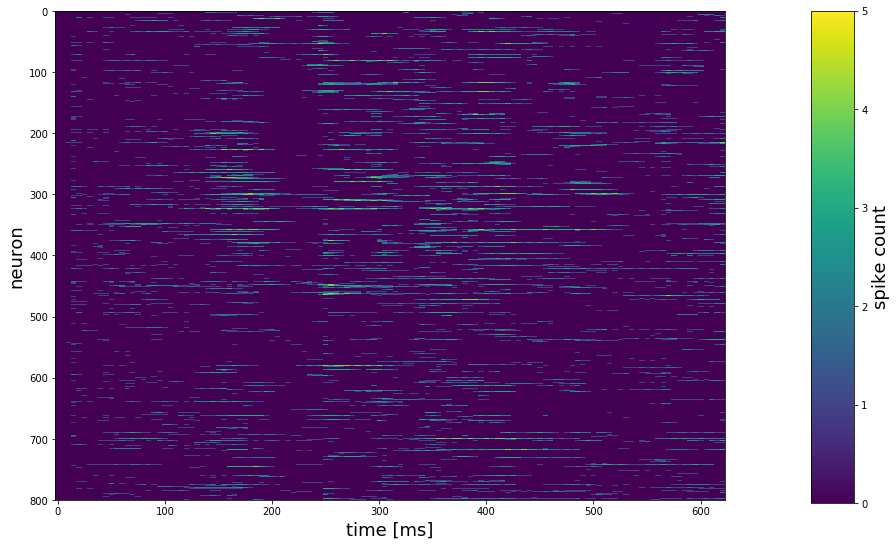

In [37]:
ro = X[110]
fig, ax = plt.subplots(figsize=(12, 9))
im = ax.imshow(ro.T, origin='upper', interpolation='nearest', aspect='auto')
ax.set_ylabel("neuron", fontsize=18)
ax.set_xlabel("time [ms]", fontsize=18)
ax.set_xticks([i*20 for i in range(7)])
ax.set_xticklabels([i*20*5 for i in range(7)])
ax_cbar = fig.add_axes([1, 0.12, 0.05, 0.76])
cb = plt.colorbar(im, cax=ax_cbar, orientation='vertical', label='spike count')
cb.set_label(label='spike count', fontsize=18)
plt.savefig("../images/recurrent-activity.pdf", bbox_inches="tight")

# Classifier

Let's run the classifier at every time step to measure the accuracy over time. We use logistic regression as the linear classifier.

In [5]:
k = X[0].shape[0]
ro_time = np.arange(k)*bin_size
accuracy = np.zeros(k)
feature_importance = []
with warnings.catch_warnings():
    warnings.filterwarnings('error')
    for i in tqdm(range(k)):
        samples = []
        labels = []
        for m in range(len(modulations)):
            idx = np.where(Y==m)[0]
            for x in X[idx]:
                samples.append(x[i])
                labels.append(m)
        clf = LogisticRegression(solver='lbfgs', multi_class='multinomial')
        try:
            clf.fit(samples, labels)
        except ConvergenceWarning:
            feature_importance.append([])
            pass
        else:
            score = clf.score(samples, labels)
            accuracy[i] = score
            f_imp = np.std(samples, 0)*clf.coef_
            feature_importance.append(f_imp)

100%|██████████| 125/125 [00:26<00:00,  5.71it/s]


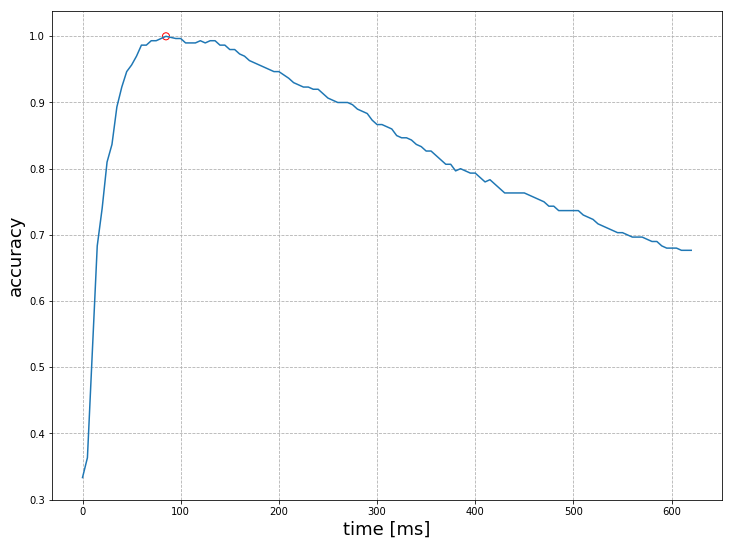

In [6]:
idx = np.nonzero(accuracy)
fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(ro_time[idx], accuracy[idx])
ax.scatter(ro_time[np.argmax(accuracy[1:])]+5, np.max(accuracy[1:]), s=50, marker='o', facecolors='None', edgecolors='red')
ax.set_ylabel("accuracy", fontsize=18)
ax.set_xlabel("time [ms]", fontsize=18)
ax.grid(True, linestyle='dashed')
plt.savefig(folder+"/accuracy.pdf", bbox_inches="tight")

In [7]:
np.argmax(accuracy)

17

In [8]:
np.argmin(accuracy)

2

In [9]:
max_idx = np.argmax(accuracy)

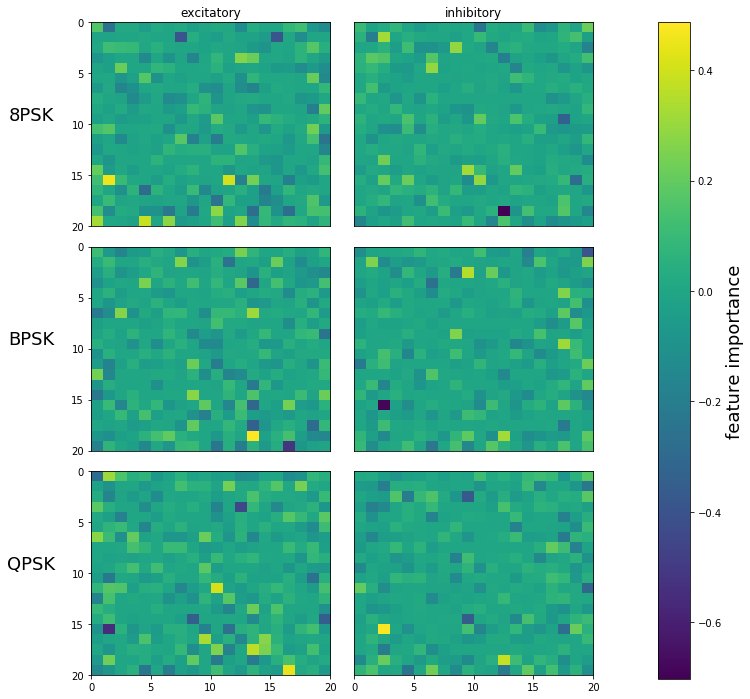

In [10]:
fig = plt.figure(figsize=(9, 12))
grid = grs.GridSpec(len(modulations), 2, wspace=0.1, hspace=0.1)
fmax = np.max(feature_importance[max_idx])
fmin = np.min(feature_importance[max_idx])
for (i, m) in enumerate(modulations):
    ax1 = plt.Subplot(fig, grid[i*2])
    ax2 = plt.Subplot(fig, grid[i*2+1])
    f_imp = feature_importance[max_idx][i, :]
    f_imp_exc = np.reshape(f_imp[:int(N/2)], (Ngx, Ngy))
    f_imp_inh = np.reshape(f_imp[int(N/2):], (Ngx, Ngy))
    ax1.imshow(f_imp_exc, interpolation='nearest', origin='upper', aspect='auto', \
           extent=[0, 20, 20, 0], cmap='viridis', vmin=fmin, vmax=fmax)
    im = ax2.imshow(f_imp_inh, interpolation='nearest', origin='upper', aspect='auto', \
           extent=[0, 20, 20, 0], cmap='viridis', vmin=fmin, vmax=fmax)
    ax1.yaxis.set_major_locator(plt.MultipleLocator(5))
    ax2.set_yticks([])
    if i==len(modulations)-1:
        ax1.xaxis.set_major_locator(plt.MultipleLocator(5))
        ax2.xaxis.set_major_locator(plt.MultipleLocator(5))
    else:
        ax1.set_xticks([])
        ax2.set_xticks([])
    ax1.set_ylabel("{}".format(m), labelpad=40, rotation=0, fontsize=18)
    if i==0:
        ax1.set_title("excitatory")
        ax2.set_title("inhibitory")
    fig.add_subplot(ax1)
    fig.add_subplot(ax2)
ax_cbar = fig.add_axes([1, 0.12, 0.05, 0.76])
cb = plt.colorbar(im, cax=ax_cbar, orientation='vertical')
cb.set_label(label='feature importance', fontsize=18)
plt.savefig(folder+"/feature_importance_{}.pdf".format(max_idx), bbox_inches="tight")

In [11]:
imp_values = np.linspace(0.0, 0.3, num=30)
fractions = np.zeros((30, 3))
for (i, imp) in enumerate(imp_values):
    for (j, m) in enumerate(modulations):
        f_imp = feature_importance[max_idx][j, :].flatten()
        most_important = len(f_imp[np.abs(f_imp)>imp])/len(f_imp)
        fractions[i, j] = most_important*100

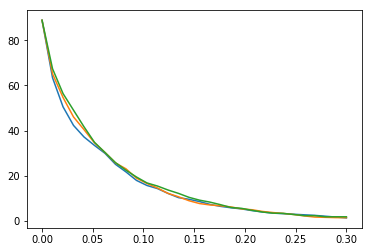

In [12]:
plt.figure()
for (i, m) in enumerate(modulations):
    plt.plot(imp_values, fractions[:, i], label="{}".format(m))

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, stratify=Y, random_state=42)
ro_time = np.arange(k)*bin_size
accuracy = np.zeros(k)
with warnings.catch_warnings():
    warnings.filterwarnings('error')
    for i in tqdm(range(k)):
        samples_train = []
        labels_train = []
        samples_test = []
        labels_test = []
        for m in range(len(modulations)):
            idx_train = np.where(Y_train==m)[0]
            for x in X_train[idx_train]:
                samples_train.append(x[i])
                labels_train.append(m)
            idx_test = np.where(Y_test==m)[0]
            for x in X_test[idx_test]:
                samples_test.append(x[i])
                labels_test.append(m)
        clf = LogisticRegression(solver='lbfgs', multi_class='multinomial')
        try:
            clf.fit(samples_train, labels_train)
        except ConvergenceWarning:
            feature_importance.append([])
            pass
        else:
            score = clf.score(samples_test, labels_test)
            accuracy[i] = score

100%|██████████| 125/125 [00:22<00:00,  6.18it/s]


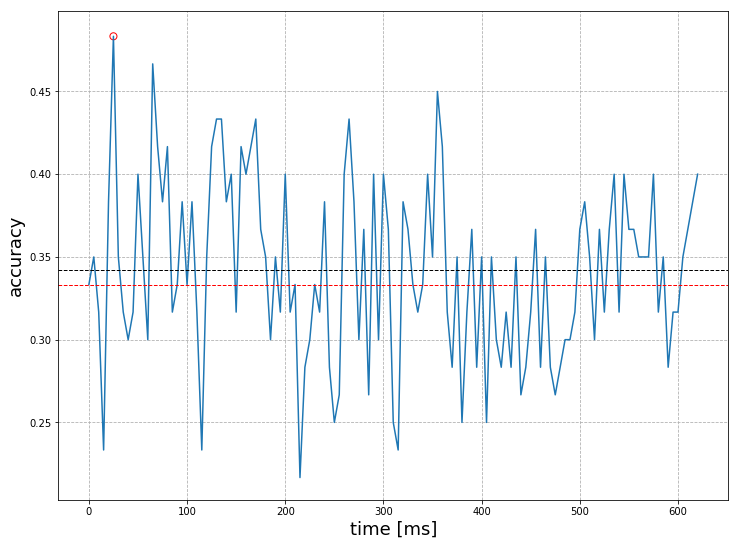

In [14]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(ro_time, accuracy)
ax.scatter(ro_time[np.argmax(accuracy[1:])]+5, np.max(accuracy[1:]), s=50, marker='o', facecolors='None', edgecolors='red')
ax.set_ylabel("accuracy", fontsize=18)
ax.set_xlabel("time [ms]", fontsize=18)
ax.axhline(np.mean(accuracy), color='black', linestyle='dashed', linewidth=1)
ax.axhline(1/len(modulations), color='red', linestyle='dashed', linewidth=1)
ax.grid(True, linestyle='dashed')
plt.savefig(folder+"/generalization-accuracy.pdf", bbox_inches="tight")

# Comparison

Let's first compare the readout states from all the samples at different time

In [15]:
selective_neurons = set()
for (i, m) in enumerate(modulations):
    f_imp = feature_importance[max_idx][j, :].flatten()
    idx = np.where(np.abs(f_imp)>0.05)[0]
    selective_neurons.update(list(idx))
selective_neurons = list(selective_neurons)

In [16]:
states = np.zeros((len(modulations), num_samples, N))
for (i, m) in enumerate(modulations):
    idx = np.where(Y==i)[0]
    for (j, x) in enumerate(X[idx]):
        states[i, j, :] = x[max_idx]

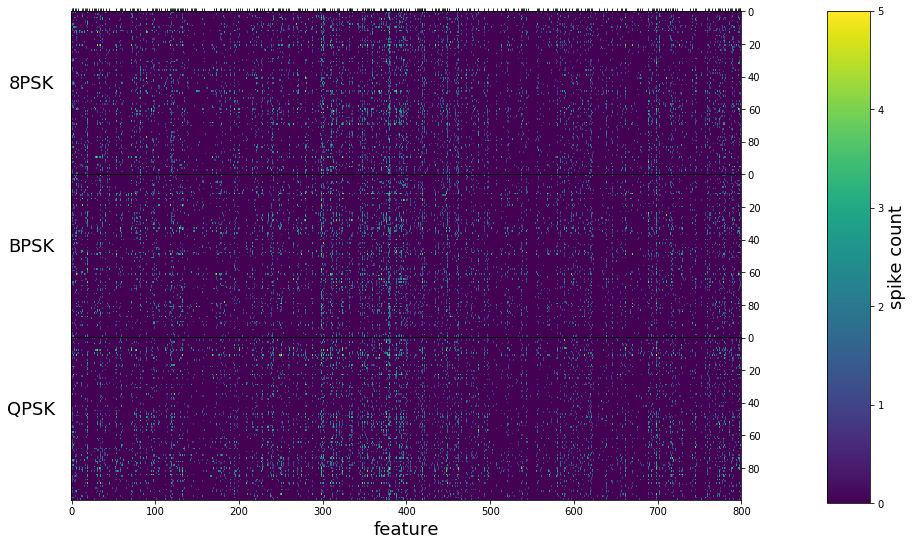

In [17]:
fig = plt.figure(figsize=(12, 9))
grid = grs.GridSpec(len(modulations), 1, wspace=0.0, hspace=0.0)
vmin = X.min()
vmax = X.max()
for (i, m) in enumerate(modulations):
    ax = plt.Subplot(fig, grid[i])
    im = ax.imshow(states[i], interpolation='nearest', aspect='auto', vmin=vmin, vmax=vmax)
    ax.set_ylabel(m, labelpad=40, rotation=0, fontsize=18)
    ax.yaxis.tick_right()
    if i==0:
        ax.xaxis.tick_top()
        ax.set_xticks(selective_neurons)
        ax.set_xticklabels([])
    elif i<len(modulations)-1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("feature", fontsize=18)
    fig.add_subplot(ax)
ax_cbar = fig.add_axes([1, 0.12, 0.05, 0.76])
cb = plt.colorbar(im, cax=ax_cbar, orientation='vertical', label='spike count')
cb.set_label(label='spike count', fontsize=18)
plt.savefig(folder+"/states_{}.pdf".format(max_idx), bbox_inches="tight")